# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [226]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import re
import pickle
% matplotlib inline


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Section 1: Business Understanding


Starbucks is a well-known brand for every coffee-lovers all over the world. Have you ever questioned that, how can they be so popular that their chain stores are covered in almost every single country. Good drinks ? Yeah of course. However, beside the quality of their beverages, Starbucks also know what exactly what the customers want, and they can easily attract the customers to consume more of their products. In this reports, I will try to find out, how can Starbucks sends out good offers to their customers by answering several question:

## 1. Which kind of offer attract the customers the most ? 

## 2. Can we classify the customers, based on some demographics features, such as age or gender ?

## 3. Which features will have high impact on customers' behaviors ?


## 4. Can we predict the customers' behaviors based on a model ?

## 5. Can we make any advice for Starbucks to attract more ?

# Section 2: Data Understanding

## 2.1. Portfolio:

Dataset overview:
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [227]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We can see that there is 10 rows of data, without nan values. Next, we should see some distributions of data.

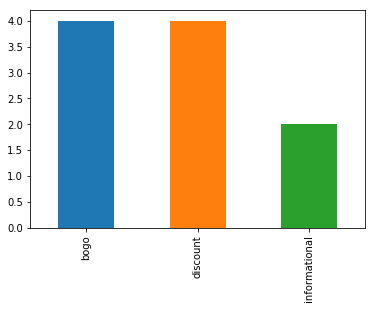

In [228]:
# Plot the distribution of offer_type:
portfolio['offer_type'].value_counts().plot(kind = 'bar')

BOGO and Discount are more frequently used than Informational.

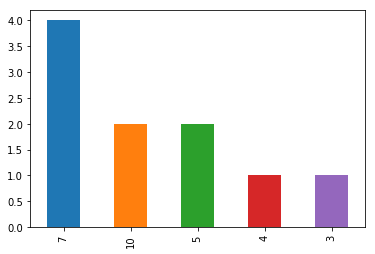

In [229]:
# Plot the distribution of duration:
portfolio['duration'].value_counts().plot(kind = 'bar')

The most used duration is 7 days.

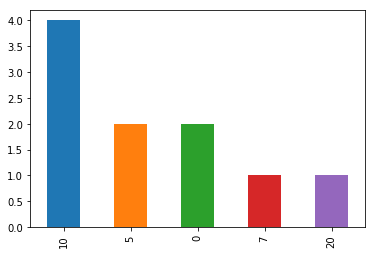

In [230]:
# Plot the distribution of difficulty:
portfolio['difficulty'].value_counts().plot(kind = 'bar')

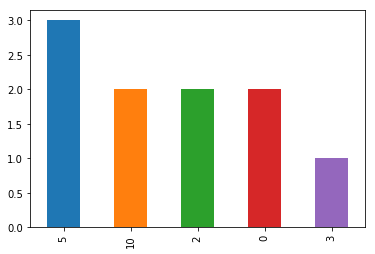

In [231]:
# Plot the distribution of reward:
portfolio['reward'].value_counts().plot(kind = 'bar')

## 2.2. Profile:

Dataset overview:
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [232]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [233]:
profile.shape

(17000, 5)

In [234]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [235]:
# Check number of null values:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We can see that 'gender' and 'income' has same amount of missing values. Let's check why:

In [236]:
profile[profile['gender'].isna()].head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [237]:
# Find customers with missing values:
cus_nan = profile[profile['gender'].isna()]['id'].tolist()


When age = 118 (an illogical number), gender and income values will be missing, so we can give a hypothesis that missing values for ages is encoded by 118. 

M    8484
F    6129
O     212
Name: gender, dtype: int64

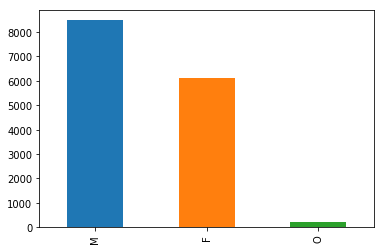

In [238]:
# Plot the distribution of genders:
profile['gender'].value_counts().plot(kind = 'bar')
profile['gender'].value_counts()

More than half of users are male.

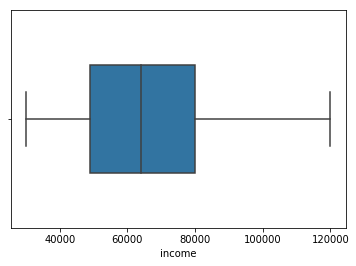

In [239]:
# Distribution of income:
sns.boxplot(profile['income'], width=0.5)

## 2.3. Transcript:

Dataset overview:
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [240]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [241]:
transcript.shape

(306534, 4)

In [242]:
# Check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

The last column is a little strange. Let's see what is this:

In [243]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

It can be seen that there are some possible values, such as 'offer id', 'offer_id','amount' ( 'offer id' and 'offer_id' could be the same).

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

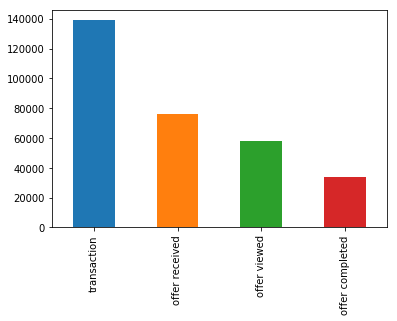

In [244]:
# Plot the distribution of events:
transcript['event'].value_counts().plot(kind = 'bar')
transcript['event'].value_counts()

# Section 3: Data Cleaning:

## 3.1. Portfolio:

We can see that, the values in column 'channels' are a bit messy and hard to follow. Let's split it into seperates column to analyze more easily.

In [245]:
# Create dummy columns based in column 'channels':
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
dummy

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [246]:
portfolio = pd.concat([portfolio, dummy], axis=1)
portfolio = portfolio.drop(columns='channels')
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


This dataset is about offer, so let's rename columns' name to distinguish.

In [247]:
portfolio = portfolio.rename(columns = {'difficulty' : 'offer_difficulty'})
portfolio = portfolio.rename(columns = {'id' : 'offer_id'})
portfolio = portfolio.rename(columns = {'duration' : 'offer_duration'})
portfolio = portfolio.rename(columns = {'reward' : 'offer_reward'})

In [248]:
portfolio

,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


## 3.2. Profile:

This dataset is about customer, so first rename the column:

In [249]:
profile = profile.rename(columns = {'id' : 'customer_id'})
profile = profile.rename(columns = {'income' : 'customer_income'})

To deal with missing values, I will drop all 2175 missing values.

In [250]:
# Drop missing values:
profile = profile.dropna(axis = 0, how = 'any')

In [251]:
profile.shape

(14825, 5)

## 3.3. Transcript:

In [252]:
# Rename the column:
transcript = transcript.rename(columns = {'person' : 'customer_id'})

We have to explore the last column. We are now seeing that as a dictionary. I will extract it into 2 columns: 

In [253]:
# Create list of key :
key_list = []
for dict in transcript['value'].tolist():
    for key in list(dict.keys()):
        if key not in key_list:
            key_list.append(key)
key_list

['offer id', 'amount', 'offer_id', 'reward']

We found that there are different keys in last column. Now split it:

In [254]:
# Extract the dictionary to coulmns:
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))

In [255]:
# Turn 'offer id' values into 'offer_id':
transcript['offer_id'] = transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
# Drop 'offer id' and 'value' column:
transcript.drop(['offer id' , 'value'] , axis=1, inplace=True)

In [256]:
# Fill missing values:
transcript.fillna(0 , inplace=True)

In [257]:
transcript.head()

,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [258]:
transcript.shape

(306534, 6)

Now, remember that we droped some customers with missing values in profile dataset. Now we have to drop them in transcript dataset too.

In [259]:
# Drop customers with missing values:
transcript = transcript[~transcript['customer_id'].isin(cus_nan)]

In [260]:
transcript.shape

(272762, 6)

## 3.4. Merging data:

In [261]:
merged_df = pd.merge(portfolio, transcript, on='offer_id')

In [262]:
merged_df = pd.merge(merged_df, profile, on='customer_id')

In [263]:
# Take a look at dataset:
merged_df.head()

,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web,event,customer_id,time,reward,amount,age,became_member_on,gender,customer_income
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,64,20170909,M,100000.0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,64,20170909,M,100000.0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,64,20170909,M,100000.0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,64,20170909,M,100000.0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,64,20170909,M,100000.0


In [264]:
merged_df.describe()

,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web,time,reward,amount,age,became_member_on,customer_income
count,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,1.488050e+05,148805.000000
mean,7.890561,6.625207,4.442445,1.0,0.917160,0.658311,0.806747,354.570223,1.078868,0.0,54.779282,2.016645e+07,66414.119149
std,5.041335,2.133035,3.372362,0.0,0.275641,0.474277,0.394851,198.311301,2.452545,0.0,17.193533,1.176936e+04,21496.947967
min,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,18.000000,2.013073e+07,30000.000000
25%,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,1.000000,168.000000,0.000000,0.0,43.000000,2.016050e+07,51000.000000
50%,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000,408.000000,0.000000,0.0,56.000000,2.017063e+07,65000.000000
75%,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000,510.000000,0.000000,0.0,67.000000,2.017122e+07,81000.000000
max,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000,714.000000,10.000000,0.0,101.000000,2.018073e+07,120000.000000


In [265]:
# Analyze the income:
merged_df['customer_income'].describe()

count    148805.000000
mean      66414.119149
std       21496.947967
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: customer_income, dtype: float64

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

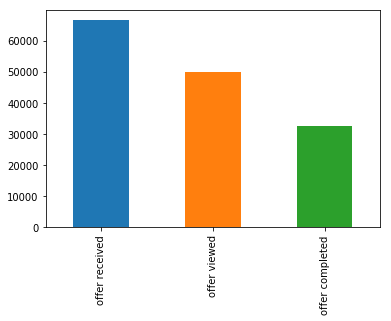

In [266]:
# Distribution of offer:
merged_df['event'].value_counts().plot(kind = 'bar')
merged_df['event'].value_counts()

It's easily understood that most offer are received, not all of them are viewed, and about half of them are completed. For me, it's a impressive percentage.

To see the trend by age, it's better if we split the data into some age groups. Each groups will present for a different period of a life:

In [267]:
# Age groups
merged_df.loc[(merged_df.age < 18) , 'Age_group'] = 'Under 18'
merged_df.loc[(merged_df.age >= 18) & (merged_df.age <= 30) , 'Age_group'] = '18-30'
merged_df.loc[(merged_df.age >= 30) & (merged_df.age <= 60) , 'Age_group'] = '30-60'
merged_df.loc[(merged_df.age >= 61) , 'Age_group'] = 'Over 60'
merged_df.drop('age',axis=1,inplace=True)

# Section 4: Modeling:

## 4.1. Modeling:

In [268]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 18 columns):
offer_difficulty    148805 non-null int64
offer_duration      148805 non-null int64
offer_id            148805 non-null object
offer_type          148805 non-null object
offer_reward        148805 non-null int64
email               148805 non-null uint8
mobile              148805 non-null uint8
social              148805 non-null uint8
web                 148805 non-null uint8
event               148805 non-null object
customer_id         148805 non-null object
time                148805 non-null int64
reward              148805 non-null float64
amount              148805 non-null float64
became_member_on    148805 non-null int64
gender              148805 non-null object
customer_income     148805 non-null float64
Age_group           148805 non-null object
dtypes: float64(3), int64(5), object(6), uint8(4)
memory usage: 17.6+ MB


Before applying model to predict the data, we should prepare it carefully:
- Encoding categorical data: offer_type, object, Age_group.
- Encoding 'event' data.
- Prepare time data became_member_on.
- Scale and normalize numerical data.

In [269]:
def cleaning_final_data(df):
    """
    Clean merged data frame for the final data.
    
    Input:
    df: data frame
    
    Output:
    df: cleaned data frame
       
    """
    # Identofy categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    # Get dummy variables:
    df = pd.get_dummies(df, columns = categorical)
    # Change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    # Add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    # Drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    # Drop offer_id and customer_id column as they are no longer neccesary:
    df.drop('offer_id',axis=1, inplace=True)  
    df.drop('customer_id',axis=1, inplace=True)  
    # Initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'reward', 'amount']
    df[numerical] = scaler.fit_transform(df[numerical])
    # Make dummy variables of 'event':
    offer_received = []
    offer_viewed = []
    offer_completed = []
    for i in df['event'].tolist():
        if i == 'offer received':
            offer_received.append(1)
            offer_viewed.append(0)
            offer_completed.append(0)
        elif i == 'offer viewed':
            offer_received.append(0)
            offer_viewed.append(1)
            offer_completed.append(0)
        elif i == 'offer completed':
            offer_received.append(0)
            offer_viewed.append(0)
            offer_completed.append(1)
    df['offer_received'] = offer_received
    df['offer_viewed'] = offer_viewed
    df['offer_completed'] = offer_completed
    # Drop 'event' table:
    df = df.drop('event', axis=1)
    return df

In [270]:
final_data = cleaning_final_data(merged_df)

In [271]:
final_data.head()

,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web,time,reward,amount,...,gender_M,gender_O,Age_group_18-30,Age_group_30-60,Age_group_Over 60,month_member,year_member,offer_received,offer_viewed,offer_completed
0,0.5,0.571429,1.0,1,1,1,0,0.000000,0.0,0.0,...,1,0,0,0,1,9,2017,1,0,0
1,0.5,0.571429,1.0,1,1,1,0,0.142857,0.0,0.0,...,1,0,0,0,1,9,2017,0,1,0
2,0.5,0.571429,1.0,1,1,1,0,0.705882,0.0,0.0,...,1,0,0,0,1,9,2017,1,0,0
3,0.5,0.571429,1.0,1,1,1,0,0.714286,0.0,0.0,...,1,0,0,0,1,9,2017,0,1,0
4,0.5,0.571429,1.0,1,1,1,0,0.714286,1.0,0.0,...,1,0,0,0,1,9,2017,0,0,1


In [272]:
# Input and Output variables:
X = final_data.drop(['offer_received', 'offer_viewed', 'offer_completed'], axis=1)
Y = final_data[['offer_received', 'offer_viewed', 'offer_completed']]

In [273]:
# Split train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 119044 rows
Testing set: 29761 rows


In [274]:
# Define function to calculate accuracy:
def class_report(Array1, Array2, col_names):
    """
    Define a metric to calculate accuracy of model.
    
    Input:
    Array1: Label set.
    Array2: Prediction set.
    col_names: Column name in output set.
    
    Output:
    df: Report shoing Precision, recall and f1 score.
       
    """
    class_report = []
    # Evaluate metrics for each set of labels
    for i in range(len(col_names)):
        precision = classification_report(Array1[:,i], Array2[:,i]).split()[-4]
        recall = classification_report(Array1[:,i], Array2[:,i]).split()[-3]
        f1 = classification_report(Array1[:,i], Array2[:,i]).split()[-2]
        class_report.append([precision, recall, f1])
    # Store metrics
    class_report = np.array(class_report)
    data_report = pd.DataFrame(data = class_report, index = col_names, columns = ['Precision', 'Recall', 'F1'])
      
    return data_report

First, I will use K-Neighbors Classifier model:

In [275]:
# Using KNN model:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [276]:
# Use the model to predict:
Y_test_pred = knn.predict(X_test)
Y_train_pred = knn.predict(X_train)

In [277]:
# Calculate accuracy for training set
col_names = ['offer_received', 'offer_viewed', 'offer_completed']
print(class_report(np.array(Y_train), Y_train_pred, col_names))

                Precision Recall    F1
offer_received       0.70   0.70  0.70
offer_viewed         0.69   0.71  0.69
offer_completed      0.94   0.94  0.94


In [278]:
# Calculate accuracy for training set:
print(class_report(np.array(Y_test), Y_test_pred, col_names))

                Precision Recall    F1
offer_received       0.48   0.48  0.48
offer_viewed         0.47   0.51  0.49
offer_completed      0.91   0.91  0.90


The accuracy is not high, I will try Random Forest Classifier model instead.


In [279]:
# Fit Random Forest Classifier model
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [280]:
# Use the model to predict:
Y_test_pred = rfc.predict(X_test)
Y_train_pred = rfc.predict(X_train)

In [281]:
# Calculate accuracy for training set
col_names = ['offer_received', 'offer_viewed', 'offer_completed']
print(class_report(np.array(Y_train), Y_train_pred, col_names))

                Precision Recall    F1
offer_received       0.94   0.94  0.94
offer_viewed         0.93   0.93  0.93
offer_completed      1.00   1.00  1.00


In [282]:
# Calculate accuracy for training set:
print(class_report(np.array(Y_test), Y_test_pred, col_names))

                Precision Recall    F1
offer_received       0.71   0.71  0.71
offer_viewed         0.70   0.71  0.70
offer_completed      1.00   1.00  1.00


## 4.2. Improve the model:

The accuracy is higher, but it's still not satisfied. Now I will try to fine-tune the model using GridSearch.

Because F1 score is combination index of Precision and Recall, I will use F1 score to find better parameters.

In [283]:
# Define f1 metric for use in grid search scoring object
def f1_metric(y_true, y_pred):
    f1_list = []
    for i in range(np.shape(y_pred)[1]):
        f1 = f1_score(np.array(y_true)[:, i], y_pred[:, i])
        f1_list.append(f1)
        
    avg_f1 = np.mean(f1_list)
    return avg_f1

In [284]:
# Get the parameters of the model:
rfc.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

For Random Forest model, here are parameters which will increase the predictive power of the model:

- max_features: Increasing max_features generally improves the performance of the model as at each node now we have a higher number of options to be considered.
- n_estimators: This is the number of trees you want to build before taking the maximum voting or averages of predictions.
- min_sample_leaf: If you have built a decision tree before, you can appreciate the importance of minimum sample leaf size. Leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data. Therefore, I will use these parameters for tuning:

In [285]:
# Grid search

parameters = {'max_features': ['auto', 'sqrt'],
              'n_estimators':[10, 25], 
              'min_samples_leaf':[1, 2, 5]}

scorer = make_scorer(f1_metric)
cv = GridSearchCV(rfc, param_grid = parameters, scoring = scorer, verbose = 10)

# Find best parameters
T_model = cv.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, score=0.7381172170670206, total=   1.8s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, score=0.7577105353710056, total=   1.8s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, score=0.7514381365971291, total=   1.9s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=25 ..........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=25, score=0.7638203562730612, total=   4.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=25 ..........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=25, score=0.7596445669372756, total=   4.4s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=25 ..........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=25, score=0.759964104318454, total=   4.6s
[CV] max_features=auto, min_samples_leaf=2, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.9s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=2, n_estimators=10, score=0.7879725896534101, total=   1.5s
[CV] max_features=auto, min_samples_leaf=2, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.8s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=2, n_estimators=10, score=0.7902700888769179, total=   1.7s
[CV] max_features=auto, min_samples_leaf=2, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.9s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=2, n_estimators=10, score=0.7770958987638767, total=   1.6s
[CV] max_features=auto, min_samples_leaf=2, n_estimators=25 ..........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.9s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=2, n_estimators=25, score=0.8038037305893351, total=   4.2s
[CV] max_features=auto, min_samples_leaf=2, n_estimators=25 ..........
[CV]  max_features=auto, min_samples_leaf=2, n_estimators=25, score=0.7970121334690882, total=   4.1s
[CV] max_features=auto, min_samples_leaf=2, n_estimators=25 ..........
[CV]  max_features=auto, min_samples_leaf=2, n_estimators=25, score=0.7877600353710453, total=   4.4s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, score=0.8118834096229358, total=   1.5s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, score=0.8050058509244421, total=   1.4s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, score=0.7907324671848034, total=   1.5s
[CV] max_features=auto, min_sampl

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.1min finished


In [286]:
# Grid search results
T_model.cv_results_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([ 1.61981018,  4.04453818,  1.39906589,  3.79802799,  1.33583061,
         3.375633  ,  1.63951993,  3.99587369,  1.47191445,  3.60942094,
         1.27764845,  3.33566737]),
 'std_fit_time': array([ 0.0201985 ,  0.07711652,  0.08096266,  0.12067767,  0.05713483,
         0.08755188,  0.03136925,  0.0245758 ,  0.05014335,  0.10717334,
         0.03185481,  0.11511156]),
 'mean_score_time': array([ 0.20476357,  0.45190835,  0.19120407,  0.41623306,  0.16665355,
         0.35314655,  0.20401073,  0.4710985 ,  0.19005092,  0.42118716,
         0.16559092,  0.35430209]),
 'std_score_time': array([ 0.0009338 ,  0.00563967,  0.00127793,  0.00289518,  0.00062332,
         0.00164491,  0.00450149,  0.03056835,  0.00175123,  0.00319257,
         0.00168025,  0.00419229]),
 'param_max_features': masked_array(data = ['auto' 'auto' 'auto' 'auto' 'auto' 'auto' 'sqrt' 'sqrt' 'sqrt' 'sqrt'
  'sqrt' 'sqrt'],
              mask = [False False False False False False False False 

In [287]:
#Top mean score
np.max(T_model.cv_results_['mean_test_score'])

0.81514656066790392

In [288]:
# Parameters for top mean score
T_model.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 25}

In [289]:
# evaluating metrics for test set
tuned_pred_test = T_model.predict(X_test)

class_report1 = class_report(np.array(Y_test), tuned_pred_test, col_names)

print(class_report1)

                Precision Recall    F1
offer_received       0.82   0.81  0.81
offer_viewed         0.80   0.80  0.79
offer_completed      1.00   1.00  1.00


# Section 5: Evaluate the results:

## 1. Which kind of offer attract the customers the most ? 

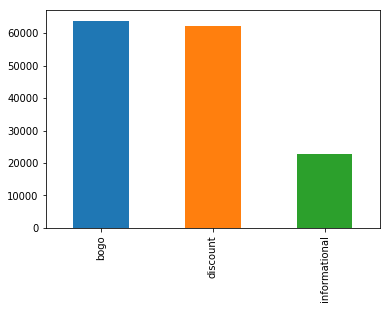

In [290]:
# Most use offer:
merged_df['offer_type'].value_counts().plot(kind = 'bar')

BOGO and Discount are approximately equal, while Informatational is not widely used.

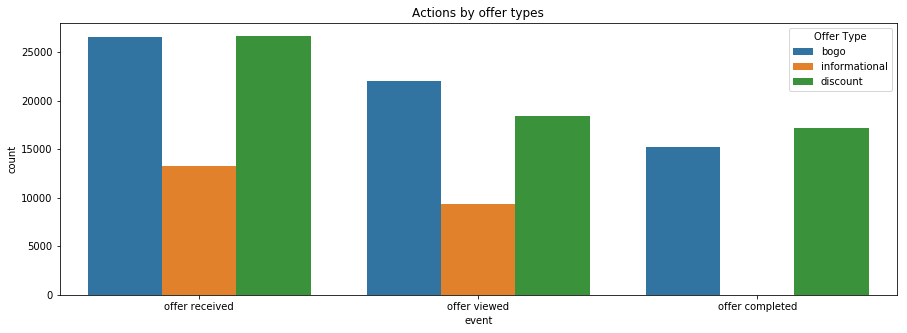

In [291]:
# Actions by offer types:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df)
plt.title('Actions by offer types')
plt.legend(title='Offer Type')

We can see that BOGO and discount are equally distributed, as Starbucks estimates the same effect of these two offer. 

At first, discount seems to be less attractive, when more people decided to view BOGO. 'Buy one get one' sounds good, because it means that you can buy 2 cups of coffees at the price of buying one. The prices of one single cup of coffees is is split in half in this case.

However, BOGO is only good when you come with a group of people (>2 people). Many people come to Starbucks alone and they want to taste the flavor of coffee here. Now, discount has more responses, while customers can buy their favorite drink at a cheaper price than usual. 'Buy one get one' can be wasteful in this case.

In conclusion, BOGO is only good when you come with a group, while Discount is welcomed any time. So offer completed with discount is a little higher, according to the graph.

About Informational, we should not invest on it ...

## 2. Can we classify the customers, based on some demographics features, such as age or gender ?

Text(0.5,1,'Actions by Age groups')

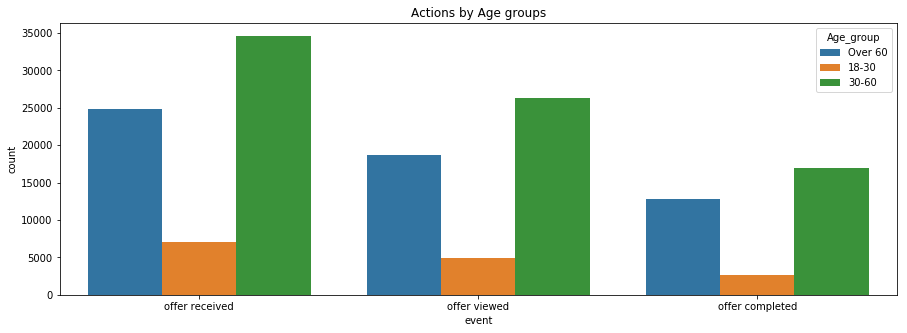

In [292]:
# Actions by Age groups:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "Age_group", data=merged_df)
plt.title('Actions by Age groups')


People from 30-60 are our favorite customers, because they are financial independent, and can easily spend money. In many country, coffee is traditional drink, and many people have for themselves a cup off coffee before starting a working day. That explain the highest amount of offer for customers at this age group.

It's surprise that age group 18-30 has a very small number of offer, compared with the others. People at this age loves going out with their friends, and coffee stores are always great choices for them to gather together. In my opinion, Starbucks prices are higher than other brands, such as Nescafé, so not many young people are ready to pay for it.



M    82896
F    63719
O     2190
Name: gender, dtype: int64

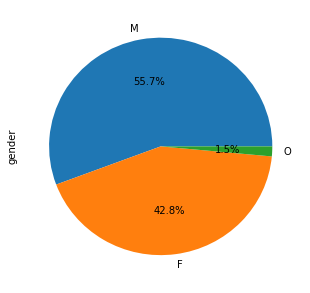

In [293]:
# Distribution of gender:
merged_df['gender'].value_counts().plot(kind = 'pie', figsize=(5, 5), autopct='%1.1f%%')
merged_df['gender'].value_counts()

Men seems to receive more offer. This ratio is quite similar to the ratio of male - female in many Societies. Now let's look at their behavior after receving the offer.

Text(0.5,1,'Actions by gender')

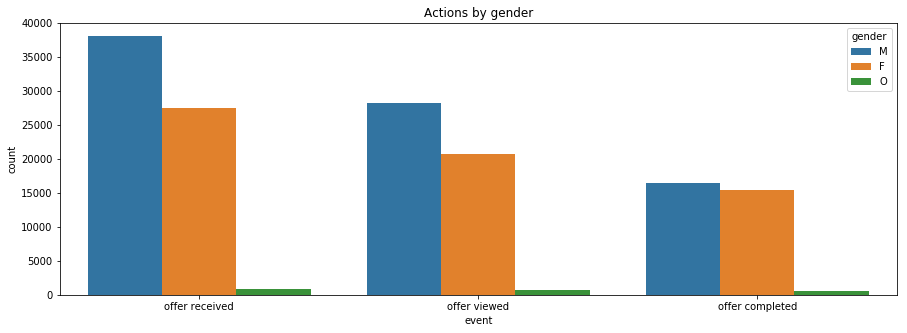

In [294]:
# Actions by gender:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=merged_df)
plt.title('Actions by gender')

We can see that the difference between Men and Women is becoming smaller, from right to left. 

Many man receive an offer, but not all of them is attracted by it, while the ratio offer_viewed / offer_received is higher for women. And it's interesting that, although more men receives offer, women is more likely to complete it. The number of offer completed of two genders is quite similar, but of course, the ratio offer_completed / offer_received of women will be higher. For me, it's very reasonable, because women loves discount (just kidding haha). We should send more offer to women.

## 3. Which features will have high impact on customers' behaviors ?


In [295]:
# Find weights of feautures:
pd.DataFrame({'rating': rfc.feature_importances_, 'featue': X.columns}).sort_values(by = 'rating', ascending = False)

,rating,featue
8,0.401602,reward
7,0.347183,time
10,0.106659,customer_income
20,0.080495,month_member
21,0.023271,year_member
2,0.009078,offer_reward
5,0.007050,social
0,0.005907,offer_difficulty
1,0.004149,offer_duration
13,0.002714,offer_type_informational


Reward and Time have a high rating, it means that customer would care more about the duration and the reward of the offers. Customer Income is another important feature, while people with lower income will be more attracted by offers.

## 4. Can we predict the customers' behaviors based on a model ?

In [296]:
# evaluating metrics for test set:
tuned_pred_test = T_model.predict(X_test)

class_report1 = class_report(np.array(Y_test), tuned_pred_test, col_names)

print(class_report1)

                Precision Recall    F1
offer_received       0.82   0.81  0.81
offer_viewed         0.80   0.80  0.79
offer_completed      1.00   1.00  1.00


In [297]:
# evaluating metrics for train set:
tuned_pred_train = T_model.predict(X_train)

class_report2 = class_report(np.array(Y_train), tuned_pred_train, col_names)

print(class_report2)

                Precision Recall    F1
offer_received       0.91   0.89  0.89
offer_viewed         0.90   0.89  0.89
offer_completed      1.00   1.00  1.00


We can see that, the model has a quite high accuracy with its predictions. Especialy with the most important label is offer_completed, the score is very impressive.

## 5. Can we make any advice for Starbucks to attract more ?

In [298]:
# Predict on the whole set:
predict = T_model.predict(X)

In [299]:
# Extract list of positions where the model predict offer_completed:
positions = []
for i in range(len(predict[:,2])):
    if predict[:,2][i] == 1:
        positions.append(i)
len(positions)

32444

In [300]:
# Find out when the predictors would be offer_completed:
offer_completed_df = merged_df.iloc[positions]

In [301]:
# Take a look at the data:
offer_completed_df.head()

,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web,event,customer_id,time,reward,amount,became_member_on,gender,customer_income,Age_group
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,Over 60
9,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,180,5.0,0.0,20170909,M,100000.0,Over 60
11,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,480,5.0,0.0,20170909,M,100000.0,Over 60
16,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,offer completed,1e9420836d554513ab90eba98552d0a9,198,10.0,0.0,20170925,M,70000.0,18-30
19,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,offer completed,1e9420836d554513ab90eba98552d0a9,414,10.0,0.0,20170925,M,70000.0,18-30


In [302]:
# Income range:
offer_completed_df.describe()['customer_income']

count     32444.000000
mean      69430.803847
std       21604.250324
min       30000.000000
25%       53000.000000
50%       69000.000000
75%       85000.000000
max      120000.000000
Name: customer_income, dtype: float64

We should send our offer to people whose income is from 53.000 - 85.000.

In [303]:
# Income range:
offer_completed_df.describe()[['email', 'mobile', 'social', 'web']]

,email,mobile,social,web
count,32444.0,32444.000000,32444.000000,32444.000000
mean,1.0,0.895636,0.646005,0.887283
std,0.0,0.305737,0.478215,0.316252
min,1.0,0.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,1.000000
50%,1.0,1.000000,1.000000,1.000000
75%,1.0,1.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000


Email is a very effective ways to send offer. We can also use mobile or web.

In conclusion, to attract more people by special offers. Starbucks should send more offer to people who is from 30 - 60 years old, with income 53.000 - 85.000. Discount should be used more, because many people love it, especially women. Offers should be sent by email, mobile or web.